In [1]:
#Generate plot 1 showing the efect of moments on the temp distribution.

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
#Chicago
LAT        = 41.8781
LON        = 360-87.6298
#Bengaluru:
# LAT        = 12.9716
# LON        = 77.5946
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Chicago/'
locn       = 'Chicago'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(1)

In [5]:
cluster

In [6]:
pi_year0 = '1870'
pi_year1 = '1900'
ic_year0 = '2070'
ic_year1 = '2100'
doy      = 211 # day_of_year
date     = 'Jul30'

In [7]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 4.65 s, sys: 770 ms, total: 5.42 s
Wall time: 6.99 s


In [8]:
%%time
#Close to (LAT, LON) ;t-temp, nw - no-warming, w-warming

tw  = ds_ssp.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_year0,ic_year1))

tnw = ds_hist.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
tnw

CPU times: user 1.68 s, sys: 75.8 ms, total: 1.75 s
Wall time: 1.78 s


<xarray.DataArray 'TREFHTMX' (time: 31, member: 100)>
dask.array<getitem, shape=(31, 100), dtype=float32, chunksize=(10, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 41.94
    lon      float64 272.5
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1870-07-30 00:00:00 ... 1900-07-30 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [9]:
%%time
#d = day/daily
tdnw = tnw.stack(mtime=('member','time'),create_index=False)
tdw  = tw.stack(mtime=('member','time'),create_index=False)
#twj30.mean().values - tnwj30.mean().values 
#tdw.std().values 
tdnw

CPU times: user 32.9 ms, sys: 3.23 ms, total: 36.1 ms
Wall time: 31.5 ms


<xarray.DataArray 'TREFHTMX' (mtime: 3100)>
dask.array<reshape, shape=(3100,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 41.94
    lon      float64 272.5
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 1870-07-30 00:00:00 ... 1900-07-30 00:00:00
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [10]:
# Set paths for local tmax - warming, no warming and corrected.
dnw_path  = cvals+loc+'tnw'+date+'_'+pi_year0+'_'+pi_year1+'_loc.nc'
dw_path   = cvals+loc+'tw'+date+'_'+ic_year0+'_'+ic_year1+'_loc.nc'
dmsc_path = cvals+loc+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.nc'
dmc_path  = cvals+loc+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.nc'
print(dnw_path) 
print(dw_path)
print(dmc_path)

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tnwJul30_1870_1900_loc.nc
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/twJul30_2070_2100_loc.nc
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tmcJul30_2070_2100_loc.nc


In [11]:
%%time
# Save daily,local tmax, mc = mean corrected, ms = mean and std-corrected
tdmc   = (tdnw - tdnw.mean())+tdw.mean()
tdmsc  = (tdnw - tdnw.mean())*(tdw.std()/tdnw.std()) + tdw.mean()
#Check if the transformation is correct
#tdmc.mean().values - tdw.mean().values
# tdnw.to_dataset().to_netcdf(dnw_path,mode='w')
# tdw.to_dataset().to_netcdf(dw_path,mode='w')
# tdmc.to_dataset().to_netcdf(dmc_path,mode='w')
# tdmsc.to_dataset().to_netcdf(dmsc_path,mode='w')

CPU times: user 371 ms, sys: 26.8 ms, total: 398 ms
Wall time: 381 ms


In [12]:
#tdmsc.mean().values - tdw.mean().values

In [13]:
#tdmsc.std().values - tdw.std().values

In [14]:
tdmc

<xarray.DataArray 'TREFHTMX' (mtime: 3100)>
dask.array<add, shape=(3100,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 41.94
    lon      float64 272.5
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 1870-07-30 00:00:00 ... 1900-07-30 00:00:00
Dimensions without coordinates: mtime

In [15]:
%%time
tdnw    = xr.open_mfdataset(dnw_path,engine='netcdf4')
tdw     = xr.open_mfdataset(dw_path,engine='netcdf4')
tdmc    = xr.open_mfdataset(dmc_path,engine='netcdf4')
tdmsc   = xr.open_mfdataset(dmsc_path,engine='netcdf4')
tdw     = tdw.TREFHTMX
tdnw    = tdnw.TREFHTMX
tdmsc   = tdmsc.TREFHTMX
tdmc    = tdmc.TREFHTMX

CPU times: user 304 ms, sys: 42.6 ms, total: 346 ms
Wall time: 434 ms


In [16]:
%%time
#Compute quantile function - Jan 1 tmax
quants = np.arange(0,1.001,0.001)
qdnw   = tdnw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdw    = tdw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc   = tdmc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmsc  = tdmsc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdw

CPU times: user 114 ms, sys: 8.73 ms, total: 122 ms
Wall time: 114 ms


<xarray.DataArray 'TREFHTMX' (quantile: 1001)>
dask.array<transpose, shape=(1001,), dtype=float64, chunksize=(1001,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999 1.0

In [17]:
# qdwa  = qdw-qdnw
# qdca  = qdc-qdnw #w= warming, a = anomaly
# qdmca = qdc-qdnw
qdw   = qdw.rename({'quantile':'permilles'})
qdmc  = qdmc.rename({'quantile':'permilles'})
qdmsc = qdmsc.rename({'quantile':'permilles'})
qdnw  = qdnw.rename({'quantile':'permilles'})

In [18]:
qdw_path    = cvals+loc+'qw'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdnw_path   = cvals+loc+'qnw'+date+'_'+pi_year0+'_'+pi_year1+'.zarr'
qdmc_path   = cvals+loc+'qmc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdmsc_path  = cvals+loc+'qmsc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

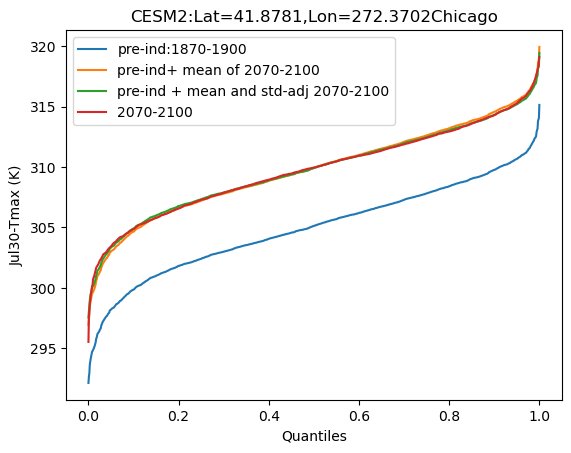

CPU times: user 7.2 s, sys: 1.49 s, total: 8.69 s
Wall time: 12.3 s


In [19]:
%%time
plt.plot(quants,qdnw,label='pre-ind:'+pi_year0+'-'+pi_year1)
plt.plot(quants,qdmc,label='pre-ind+ mean of '+ic_year0+'-'+ic_year1)
plt.plot(quants,qdmsc,label='pre-ind + mean and std-adj '+ic_year0+'-'+ic_year1)
plt.plot(quants,qdw,label= ic_year0+'-'+ic_year1)
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON)+locn)
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [20]:
tdw

<xarray.DataArray 'TREFHTMX' (mtime: 3100)>
dask.array<open_dataset-6b0b2d218fa9fcb76b02abf5e13ed503TREFHTMX, shape=(3100,), dtype=float32, chunksize=(3100,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 ...
    lon      float64 ...
    member   (mtime) int64 dask.array<chunksize=(3100,), meta=np.ndarray>
    time     (mtime) object dask.array<chunksize=(3100,), meta=np.ndarray>
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [21]:
%%time
######## Boostrap Confidence Intervals for the quantiles #####
#a = anopmaly, b=bootstrap samples
nboot   = 1000
# tdnwb   = xs.resample_iterations(tdnw,nboot,'mtime')
# tdcb    = xs.resample_iterations(tdc,nboot,'mtime')
# tdmcb   = xs.resample_iterations(tdmc,nboot,'mtime')
tdwb    = xs.resample_iterations(tdw,nboot,'mtime')
# qdnwb   = tdnwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdcb    = tdcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdmcb   = tdmcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdwab   = qdwb - qdnwb
# qdcab   = qdcb - qdnwb
# qdmcab  = qdmcb - qdnwb
qdwb    = tdwb.chunk(dict(mtime=-1,iteration=-1)).quantile(quants,dim='mtime')
qdwb

CPU times: user 51.1 s, sys: 3.29 s, total: 54.4 s
Wall time: 51.3 s


<xarray.DataArray 'TREFHTMX' (quantile: 1001, iteration: 1000)>
dask.array<transpose, shape=(1001, 1000), dtype=float64, chunksize=(1001, 1000), chunktype=numpy.ndarray>
Coordinates:
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * quantile   (quantile) float64 0.0 0.001 0.002 0.003 ... 0.998 0.999 1.0

In [22]:
%%time
#qdwb_path  = cvals+loc+'qdw_10kboot' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdwb_path  = cvals+loc+'qdw' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdwb.to_dataset().to_zarr(qdwb_path)
# qdwb       = xr.open_zarr(qdwb_path)

CPU times: user 0 ns, sys: 37 µs, total: 37 µs
Wall time: 59.6 µs


In [23]:
%%time
qdwb     = qdwb.rename({'quantile':'permilles'})
CIs      = [0.025,0.5,0.975]
qdw_ci   = qdwb.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')

CPU times: user 76 ms, sys: 4.07 ms, total: 80 ms
Wall time: 73.4 ms


In [ ]:
%%time
#Check for bootstrap bias
plt.hist(qdwb.sel(permilles=0.025),density='True',bins=30,label='q=0.025;'+ic_year0+'_'+ic_year1)
plt.xlabel(date+' Tmax(K), CESM2')
plt.ylabel('Prob density')
plt.title(locn+',Lat='+str(LAT)+',Lon='+str(LON))
plt.legend(loc='upper right')
plt.show()

In [ ]:
qdw.sel(permilles=0.025).values
# End of bootstrap bias check

In [ ]:
%%time
#Check for bootstrap bias
plt.hist(qdwb.sel(permilles=0.975),density='True',bins=30,label='q=0.975;'+ic_year0+'_'+ic_year1)
plt.xlabel(date+' Tmax(K), CESM2')
plt.ylabel('Prob density')
plt.title(locn+',Lat='+str(LAT)+',Lon='+str(LON))
plt.legend(loc='upper right')
plt.show()

In [ ]:
%%time
## Save CIs
qdw_cipath  = cvals+loc+'qdw_ci' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdw_ci.to_dataset().to_zarr(qdw_cipath,mode='w')

In [ ]:
%%time
qdw_ci   = xr.open_mfdataset(qdw_cipath,engine='zarr')
qdw_ci   = qdw_ci.TREFHTMX

In [ ]:
qdw_ci

In [ ]:
qdw_cimean = qdw_ci.mean('quantile')
qdw_cimean

In [ ]:
%%time
#plt.plot(quants,qdnw,label=pi_year0+'_'+pi_year1)
plt.plot(quants,qdw,label=ic_year0+'_'+ic_year1,c='g')
#plt.plot(quants,qdmc,label= 'mean-adj')
#plt.plot(quants,qdmsc,label='mean and std-adj')
plt.fill_between(quants,qdw_ci.sel(quantile=0.025),qdw_ci.sel(quantile=0.975),color='r',alpha=0.1)
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn)
plt.ylabel(date+'Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
%%time
quants  = np.arange(0,1.001,0.001)
plt.plot(quants,qdw_ci.sel(quantile=0.025)-qdw,color='r',label='CI_lb-actual')
plt.plot(quants,qdw_ci.sel(quantile=0.975)-qdw,color='g',label='CI_ub- actual')
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn+',bootstrap CIs')
plt.ylabel(date+'Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
%%time
quants  = np.arange(0,1.001,0.001)
plt.plot(quants,qdw-qdw_ci.sel(quantile=0.025),color='r',label='actual-CI_lb')
plt.plot(quants,qdw_ci.sel(quantile=0.975)-qdw,color='g',label='CI_ub- actual')
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn+',bootstrap CIs')
plt.ylabel(date+'Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
qdw_ci.sel(quantile=0.025).values

In [ ]:
qdw_ci.sel(quantile=0.975).values

In [ ]:
qdw.values

In [ ]:
%%time
lb = (qdw_ci.sel(quantile=0.025)- qdw).to_numpy()
ub = (qdw_ci.sel(quantile=0.975)- qdw).to_numpy()

In [ ]:
np.set_printoptions(threshold=np.Inf)

In [ ]:
print(ub)

In [ ]:
print(lb)

In [ ]:
count = qdw.where((qdw_ci.sel(quantile=0.025)<=qdw)|\
                   (qdw <= qdw_ci.sel(quantile=0.975))).count()

In [ ]:
count.values

In [ ]:
qdw

In [ ]:
qdw.values

In [ ]:
qdw_ci.sel(quantile=0.025).values

In [ ]:
count2 = qdw.where((qdw_ci.sel(quantile=0.025)<=qdmsc)|\
                   (qdmsc <= qdw_ci.sel(quantile=0.975))).count()

In [ ]:
count2.values